In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

pd.set_option('display.max_columns', None)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from scipy.stats import skew, norm, zscore
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

##### Importing and combining data:
You begin by importing your train and test data and combining them into a single dataframe. This allows you to perform data preprocessing on the entire dataset.

In [97]:
path_to_data = r'C:\Users\User\Desktop\Main Folder\Job\Projects\Titanic - Machine Learning from Disaster\\'
train = pd.read_csv(path_to_data + str('train.csv'))
test = pd.read_csv(path_to_data + str('test.csv'))

survived_list = train['Survived']

train_index = train.index
test_index = test.index

train = train.drop(['Survived'], 1)
data = pd.concat([train, test]).reset_index(drop = True)

In [98]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Dropping uninformative columns: 
After combining your data, you identify columns that are not informative for your problem and drop them from the dataframe. This helps to reduce noise and focus on the important features.

In [99]:
unnecessary_columns = ['Name', 'Ticket']

def remove_unnecessary_columns(dataframe, unnecessary_columns):
    
    dataframe = dataframe.drop(unnecessary_columns, 1)
    
    return dataframe

data = remove_unnecessary_columns(data, unnecessary_columns)

##### Checking dataset information: 
You then display the overall information about your dataset, such as the number of rows, columns, and data types. This helps you to get a better understanding of the data you are working with.

In [100]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Sex          1309 non-null   object 
 3   Age          1046 non-null   float64
 4   SibSp        1309 non-null   int64  
 5   Parch        1309 non-null   int64  
 6   Fare         1308 non-null   float64
 7   Cabin        295 non-null    object 
 8   Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 92.2+ KB


##### Handling missing values: 
Next, you check the amount of null values in each column of the dataset.

In [101]:
columns_with_nan = data.isna().sum()[data.isna().sum() != 0]
columns_with_nan

Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

For columns 'Age' and 'Fare' which contain missing values, you fill them in using mean values based on the similarity of other values in the same columns. Specifically,
- Find the most correlated columns to 'Age' (let's say 'Pclass' and 'SibSp');
- Find standard deviations for 'Pclass' and 'SibSp';
- Use that standard deviations to find similar values in columns 'Pclass' and 'SibSp' to row 'x' values;
- Take the mean of 'Age' of those similar rows and set it instead of 'nan' value in row 'x' columns 'Age'

This helps to ensure that your dataset is complete and suitable for analysis.

In [102]:
for column in ['Age', 'Fare']:
    
    values = []
    
    correlated_columns = abs(data.corr()[column]).sort_values(ascending = False)[1:3].index
    indecies = data.loc[data[column].isna(), column].index
    
    for index in indecies:
        
        value = data[(data[correlated_columns[0]] == data.iloc[index][correlated_columns[0]]) &
                 (data[correlated_columns[1]] == data.iloc[index][correlated_columns[1]])][column].mean(skipna = True)
        
        values.append(value)
        
    data.loc[indecies, column] = values        

##### Data type conversion and feature engineering: 
You convert the 'Age' column into 'int' datatype and fill missing values in object columns with "NA". You also separate the first character of the cabin column and set it as a new value in the 'Cabin' column. Additionally, you create three new columns: 
- 'are_siblings' to indicate whether a passenger has any siblings;
- 'are_parents' to indicate whether a passenger has any parents;
- 'family_size' to indicate the size of a family traveling with the passenger.

These steps help to further refine your dataset and create more meaningful features for analysis.

In [103]:
data['Age'] = data['Age'].astype(int)

data[['Cabin', 'Embarked']] = data[['Cabin', 'Embarked']].fillna('NA')
data['Cabin'] = data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) and x != 'NA' else x)

data['are_siblings'] = data['SibSp'].apply(lambda x: 1 if x != 0 else 0)
data['are_parents'] = data['Parch'].apply(lambda x: 1 if x != 0 else 0)
data['family_size'] = data['SibSp'] + data['Parch']

##### Descriptive statistics: 
You check the descriptive statistics of the dataset to get an overview of the range, mean, and standard deviation of each variable. This helps to identify any potential outliers or data skewness.

In [104]:
data.drop('PassengerId', 1).describe().T

,count,mean,std,min,25%,50%,75%,max
Pclass,1309.0,2.294882,0.837836,1.0,2.0000,3.0000,3.000,3.0000
Age,1309.0,29.427044,13.184479,0.0,22.0000,27.0000,37.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.0,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.0,0.0000,0.0000,0.000,9.0000
Fare,1309.0,33.277580,51.742932,0.0,7.8958,14.4542,31.275,512.3292
are_siblings,1309.0,0.319328,0.466394,0.0,0.0000,0.0000,1.000,1.0000
are_parents,1309.0,0.234530,0.423867,0.0,0.0000,0.0000,0.000,1.0000
family_size,1309.0,0.883881,1.583639,0.0,0.0000,0.0000,1.000,10.0000


##### Skewness and outlier detection: 
You check for data skewness and clean any outliers.

In [105]:
skewness = data.drop('PassengerId', 1).skew()
skewness.sort_values(ascending = False)

Fare            4.369316
SibSp           3.844220
Parch           3.669078
family_size     2.853078
are_parents     1.254527
are_siblings    0.775947
Age             0.503033
Pclass         -0.598647
dtype: float64

Specifically, you consider data with a skewness threshold over 1 as skewed and apply different transformations, such as:
- square root;
- cube root;
- logarithm;
- BoxCox transformations,

to find the best transformation for each skewed column. You then apply these transformations to the skewed columns, resulting in a reduction in the number of outliers in the dataset.

In [106]:
def square_root_transformation(dataframe, columns):
    
    dataframe[columns] = np.sqrt(dataframe[columns]+0.001)
    return dataframe

def cube_root_transformation(dataframe, columns):
    
    dataframe[columns] = (dataframe[columns]+0.001)**(1/3)
    return dataframe

def logarithm_transformation(dataframe, columns):
    
    dataframe[columns] = np.log(dataframe[columns]+0.001)
    return dataframe

def boxcox_transformation(dataframe, column):
    dataframe[column], _ = boxcox(dataframe[column] + 0.001)
    return dataframe

In [107]:
def find_outliers(dataframe, threshold=4):
    
    zscores = pd.DataFrame(np.abs(zscore(dataframe)), columns=dataframe.columns, index=dataframe.index)

    outliers = zscores > threshold

    return outliers

In [108]:
best_transformation = pd.DataFrame()

variables = []
before_transform = []
best_transformer = []
logs = []
squares = []
cubes = []
boxcox_list = []

for variable in skewness.index:
    

    variables.append(variable)
    check_column = data[[variable]]
    before_transform.append(np.abs(data[[variable]].skew()[variable]))
    square = np.abs(square_root_transformation(check_column, variable).skew()[variable])
    cube = np.abs(cube_root_transformation(check_column, variable).skew()[variable])
    log = np.abs(logarithm_transformation(check_column, variable).skew()[variable])
    from scipy.stats import boxcox
    bxcx = np.abs(boxcox_transformation(data.copy(), variable).skew()[variable])

    best_dict = {'cube': cube, 'square': square, 'log': log, 'boxcox': bxcx}
    min_var = min(best_dict, key=lambda x: best_dict[x])
    best_transformer.append(min_var)
    logs.append(log)
    squares.append(square)
    cubes.append(cube)
    boxcox_list.append(bxcx)

best_transformation['variable'] = variables
best_transformation['best_transformer'] = best_transformer
best_transformation['square'] = squares
best_transformation['cube'] = cubes
best_transformation['logs'] = logs
best_transformation['boxcox'] = boxcox_list
best_transformation['before_transform'] = before_transform

Below you can find a dataframe below that displays all the variables along with the different transformations applied to them. The purpose of this is to identify the most effective transformation for each variable and determine how each transformation affects the data.

In [109]:
best_transformation.sort_values(by = 'before_transform', ascending = False)

,variable,best_transformer,square,cube,logs,boxcox,before_transform
4,Fare,cube,2.090228,0.083792,3.419629,0.322839,4.369316
2,SibSp,boxcox,1.435691,0.872920,0.802988,0.777090,3.844220
3,Parch,boxcox,1.665244,1.320121,1.274214,1.254623,3.669078
7,family_size,boxcox,1.106536,0.548681,0.461122,0.431680,2.853078
6,are_parents,boxcox,1.254527,1.254527,1.254527,1.254527,1.254527
5,are_siblings,square,0.775947,0.775947,0.775947,0.775947,0.775947
0,Pclass,boxcox,0.709361,0.783271,0.819105,0.460233,0.598647
1,Age,boxcox,0.837023,3.431680,6.521866,0.091007,0.503033


In [110]:
def feature_engineering(dataframe, columns, best_transformation):
    
    outliers_before_update = find_outliers(dataframe[columns])
    outliers_before_update = outliers_before_update[outliers_before_update == True].dropna(how = 'all').shape[0]
    print('Amount of outliers begore transformation is: {}'.format(outliers_before_update))
    
    skewness = dataframe[columns].skew().sort_values(ascending=False)

    
    for variable in skewness.index:
        
        if skewness[variable] > 1:
            best_transformer = best_transformation[best_transformation['variable'] == variable]['best_transformer'].iloc[-1]

            if best_transformer == 'log':
                dataframe[variable] = logarithm_transformation(dataframe.copy(), variable)[[variable]]

            elif best_transformer == 'square':
                dataframe[variable] = square_root_transformation(dataframe.copy(), variable)[[variable]]

            elif best_transformer == 'cube':
                dataframe[variable] = cube_root_transformation(dataframe.copy(), variable)[[variable]]
                
            else:
                from scipy.stats import boxcox
                dataframe[variable] = boxcox_transformation(dataframe.copy(), variable)[[variable]]
        
    outliers_after_update = find_outliers(dataframe[columns])
    outliers_after_update = outliers_after_update[outliers_after_update == True].dropna(how = 'all').shape[0]
    print('Amount of outliers after transformation is: {}'.format(outliers_after_update))
    
    return dataframe

Furthermore, it is worth noting that the transformation had a significant positive impact on the amount of outliers in the data. Prior to the transformation, there were 49 outliers present, while after the transformation, the number decreased dramatically to just 4 outliers.

In [111]:
data = feature_engineering(data.copy(), best_transformation.variable, best_transformation)

Amount of outliers begore transformation is: 49
Amount of outliers after transformation is: 4


In [112]:
outliers = find_outliers(data[best_transformation.variable])
print('The total amount of oultiers is {}'.format(outliers[outliers == True].dropna(how = 'all').shape[0]))
print('='*60)
print("The biggest amount of outliers have next variables:")
print("{}\n".format(outliers.sum().sort_values(ascending=False)[:5]))

The total amount of oultiers is 4
The biggest amount of outliers have next variables:
Fare      4
Pclass    0
Age       0
SibSp     0
Parch     0
dtype: int64



##### Multicollinearity: 
You check for multicollinearity among the variables in the dataset by calculating the correlation coefficients.

<AxesSubplot: >

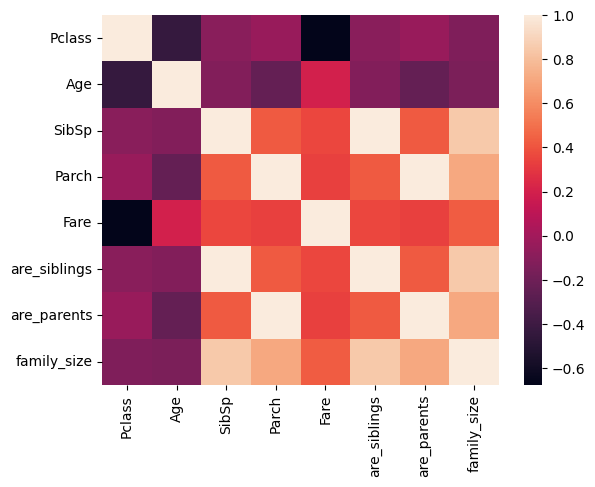

In [113]:
sns.heatmap(data.drop('PassengerId', 1).corr(), )

In [114]:
data.corr()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,are_siblings,are_parents,family_size
PassengerId,1.000000,-0.038354,0.023957,-0.022418,-0.004362,0.024180,-0.021109,-0.004318,-0.028852
Pclass,-0.038354,1.000000,-0.436775,-0.094754,-0.035231,-0.676796,-0.098335,-0.035583,-0.136549
Age,0.023957,-0.436775,1.000000,-0.125293,-0.239869,0.196460,-0.120290,-0.239969,-0.151740
SibSp,-0.022418,-0.094754,-0.125293,1.000000,0.421284,0.354764,0.999826,0.421344,0.848476
Parch,-0.004362,-0.035231,-0.239869,0.421284,1.000000,0.333439,0.417468,0.999986,0.705840
Fare,0.024180,-0.676796,0.196460,0.354764,0.333439,1.000000,0.354391,0.333062,0.427407
are_siblings,-0.021109,-0.098335,-0.120290,0.999826,0.417468,0.354391,1.000000,0.417540,0.848000
are_parents,-0.004318,-0.035583,-0.239969,0.421344,0.999986,0.333062,0.417540,1.000000,0.705736
family_size,-0.028852,-0.136549,-0.151740,0.848476,0.705840,0.427407,0.848000,0.705736,1.000000


Based on the correlation heatmap and the fact that you have only a few variables, you determine that it is better to avoid applying principal component analysis (PCA) in this case.

##### Label encoding: 
You apply label encoding to object categorical values to convert them into numerical values. This helps to prepare your dataset for machine learning models.

In [115]:
def label_encode(dataframe):
    for col in dataframe.select_dtypes(include='object'):
        if len(dataframe[col].unique()) > 2:
            le = LabelEncoder()
            dataframe[col] = le.fit_transform(dataframe[col])
        else:
            ohe = OneHotEncoder(drop='if_binary', sparse=False)
            dataframe[col] = ohe.fit_transform(dataframe[col].values.reshape(-1, 1))
    return dataframe

data = label_encode(data)

##### Train-test split: 
You divide your dataset back into train and test data and merge the 'Survived' column back into the train data.

In [134]:
train_data = data.iloc[train_index]
train_data['Survived'] = survived_list
test_data = data.iloc[test_index]

You also check if the 'Survived' column is imbalanced and decide if you need to apply stratification during the train-test split.

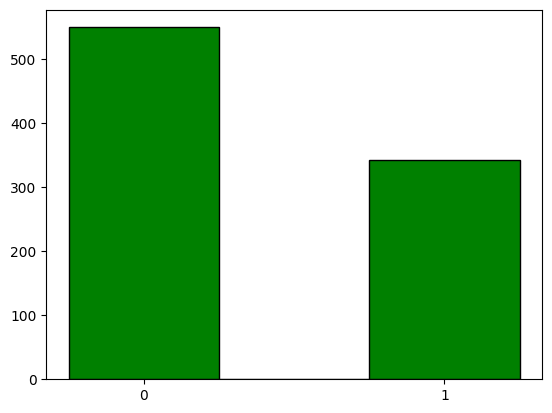

In [117]:
plt.hist(survived_list, bins=[-0.25, 0.25, 0.75, 1.25], edgecolor='black', color=['green'])
plt.xticks([0, 1], ['0', '1'])
plt.show()

The column 'Survived' does not appear to be significantly imbalanced, and thus, I will refrain from using stratification during the splitting process. At this point, we will proceed with dividing our training data into separate training and validation datasets.

In [118]:
X_train_data = train_data.drop(['PassengerId', 'Survived'], 1)
y_train_data = train_data[['Survived']]

X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size=0.3, random_state=101)

My decision was to utilize the MinMaxScaler method to standardize both the training and validation datasets.

In [119]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

##### Modelling: 
We will now proceed to experiment with different models and select the one with the highest prediction accuracy on the validation dataset. The models that we will consider are:

- Logistic Regression Model
- Random Forest Model
- SVM Model
- Gradient Boosting Model
- Neural Network Model


To optimize each model's performance, we will apply the grid_search method to find the best combination of hyperparameters for every model.

In [120]:
def logistic_regression_model(X_train, X_val, y_train, y_val):
    
    model = LogisticRegression()
    param_grid = {'penalty': ['l1', 'l2', None],
                  'C': [0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 4.0]}
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 10)
    grid_search.fit(X_train, y_train)
    
    best_penalty = grid_search.best_params_['penalty']
    best_C = grid_search.best_params_['C']
    
    model = LogisticRegression(penalty = best_penalty, C = best_C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=0)
    
    return y_pred, accuracy, model, f1

In [121]:
def random_forest_model(X_train, X_val, y_train, y_val):
    
    model = RandomForestRegressor()
    param_grid = {'n_estimators': [25, 50, 75, 100, 150, 300, 500, 750]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    best_n_estimators = grid_search.best_params_['n_estimators']
    
    model = RandomForestRegressor(n_estimators=best_n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred = np.round(y_pred).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=0)
    
    return y_pred, accuracy, model, f1

In [122]:
def svm_model(X_train, X_val, y_train, y_val):
    
    model = svm.SVC()
    param_grid = {'C': [0.05, 0.1, 0.3, 0.5, 0.75, 1.0, 2.0, 4.0],
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'gamma': ['scale', 'auto']}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    best_C = grid_search.best_params_['C']
    best_kernel = grid_search.best_params_['kernel']
    best_gamma = grid_search.best_params_['gamma']
    
    model.fit(X_train, y_train)
    
    model = svm.SVC(C = best_C, kernel = best_kernel, gamma = best_gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=0)
    
    return y_pred, accuracy, model, f1

In [123]:
def gradient_boosting_model(X_train, y_train, X_val, y_val):
    
    model = model = GradientBoostingRegressor()
    param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
                  'n_estimators': [25, 50, 75, 100, 150, 300, 500, 750]}
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search.fit(X_train, y_train)
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_n_estimators = grid_search.best_params_['n_estimators']
    
    model = GradientBoostingRegressor(learning_rate = best_learning_rate, n_estimators = best_n_estimators)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred = np.round(y_pred).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, pos_label=0)
    
    return y_pred, accuracy, model, f1

In [124]:
def neural_network_model(X_train, y_train, X_val, y_val):
    
    def create_model(n_layers, layer_size, regularizer):
        model = Sequential()
        
        div = 1
        
        for i in range(n_layers):
            model.add(Dense(int(layer_size/div), input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizer))
            div = 2
        model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizer))
        model.compile(loss='binary_crossentropy', optimizer='adam')
        return model

    model = KerasRegressor(build_fn=create_model, verbose=0)

    param_grid = {
        'n_layers': [2, 3, 4],
        'layer_size': [32, 64, 128],
        'regularizer': [regularizers.l2(0.001), regularizers.l2(0.01),
                       regularizers.l1(0.001), regularizers.l1(0.01)],
        'batch_size': [8, 16, 32]
    }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    
    best_layer_size = best_params['layer_size']
    best_n_layers = best_params['n_layers']
    best_regularizer = best_params['regularizer']
    best_batch_size = best_params['batch_size']
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    
    model = Sequential()

    div = 1
    
    for i in range(best_n_layers):
        model.add(Dense(int(best_layer_size/div), input_dim=X_train.shape[1], activation='relu', kernel_regularizer=best_regularizer))
        div = 2
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=best_regularizer))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=best_batch_size, callbacks=[early_stopping])

    # Evaluate the model on the training data
    y_pred_train = model.predict(X_train)
    y_pred_train = np.round(y_pred_train).astype(int)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Evaluate the model on the test data
    y_pred_val = model.predict(X_val)
    y_pred_val = np.round(y_pred_val).astype(int)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    
    f1 = f1_score(y_val, y_pred_val, pos_label=0)
    
    print('The accuracy on train data is {}.'.format(accuracy_train))
    print('The accuracy on val data is {}.'.format(accuracy_val))
    print('='*60)
    print('Difference between accuracy of val data and train data is {}%.'.format(((accuracy_val/accuracy_train)-1)*100))
    
    return y_pred_val, accuracy_val, model, f1

The following function trains each model and consolidates their results into a separate dataframe, making it easier to determine the best performing model.

In [125]:
def find_best_model(X_train, y_train, X_val, y_val):
    
    y_pred_lrm, accuracy_lrm, model_lrm, f1_lrm = logistic_regression_model(X_train.copy(), X_val.copy(), y_train.copy(), y_val.copy())
    print('Logistic Regression model was successfuly completed')
    y_pred_rfm, accuracy_rfm, model_rfm, f1_rfm = random_forest_model(X_train.copy(), X_val.copy(), y_train.copy(), y_val.copy())
    print('Random forest model was successfuly completed')
    y_pred_svm, accuracy_svm, model_svm, f1_svm = svm_model(X_train.copy(), X_val.copy(), y_train.copy(), y_val.copy())
    print('Support Vecotr model was successfuly completed')
    y_pred_gbm, accuracy_gbm, model_gbm, f1_gbm = gradient_boosting_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Gradient Boosting model was successfuly completed')
    y_pred_nn, accuracy_nn, model_nn, f1_nn = neural_network_model(X_train.copy(), y_train.copy(), X_val.copy(), y_val.copy())
    print('Neural Network model was successfuly completed')
    
    models = [model_lrm, model_rfm, model_svm, model_gbm, model_nn]
    
    final_results = pd.DataFrame(y_val.copy())
    model_names = ['Logistic Regression', 'Random forest', 'Support Vecotr', 'Gradient Boosting', 'Neural Network']

    final_results['logistic_regression_pred'] = y_pred_lrm
    final_results['random_forest_pred'] = y_pred_rfm
    final_results['support_vector_pred'] = y_pred_svm
    final_results['gradient_boosting_pred'] = y_pred_gbm
    final_results['neural_network_pred'] = y_pred_nn
    

    accuracy = [accuracy_lrm, accuracy_rfm, accuracy_svm, accuracy_gbm, accuracy_nn]
    f_scores = [f1_lrm, f1_rfm, f1_svm, f1_gbm, f1_nn]
    all_accuracy = {model_name: score for model_name, score in zip(model_names, accuracy)}
    all_f_scores = {model_name: score for model_name, score in zip(model_names, f_scores)}
    
    metric_dict = {'model_names':model_names,
                   'accuracy': accuracy,
                   'f1_score': f_scores}
        
    metric_dict = pd.DataFrame(metric_dict)
        
    return metric_dict, models

In [126]:
metric_dict, models = find_best_model(X_train, y_train, X_val, y_val)

Logistic Regression model was successfuly completed
Random forest model was successfuly completed
Support Vecotr model was successfuly completed
Gradient Boosting model was successfuly completed
Epoch 1/50
78/78 [==============================] - 1s 3ms/step - loss: 0.6375 - val_loss: 0.6265
Epoch 2/50
78/78 [==============================] - 0s 2ms/step - loss: 0.5451 - val_loss: 0.5606
Epoch 3/50
78/78 [==============================] - 0s 2ms/step - loss: 0.5260 - val_loss: 0.5699
Epoch 4/50
78/78 [==============================] - 0s 2ms/step - loss: 0.5089 - val_loss: 0.5356
Epoch 5/50
78/78 [==============================] - 0s 2ms/step - loss: 0.4949 - val_loss: 0.5391
Epoch 6/50
78/78 [==============================] - 0s 2ms/step - loss: 0.4947 - val_loss: 0.5200
Epoch 7/50
78/78 [==============================] - 0s 2ms/step - loss: 0.4877 - val_loss: 0.5214
Epoch 8/50
78/78 [==============================] - 0s 2ms/step - loss: 0.4824 - val_loss: 0.5156
Epoch 9/50
78/78 [===

##### Results:
Upon evaluating the different models, we can observe that the Gradient Boosting Model exhibited the best performance, achieving an accuracy score of 0.00 and an F1 score of 0.00.

In [127]:
metric_dict

,model_names,accuracy,f1_score
0,Logistic Regression,0.772388,0.812308
1,Random forest,0.783582,0.820988
2,Support Vecotr,0.798507,0.835366
3,Gradient Boosting,0.824627,0.858006
4,Neural Network,0.802239,0.845481


In [128]:
models

[LogisticRegression(C=0.05, penalty=None),
 RandomForestRegressor(n_estimators=300),
 SVC(C=0.1, kernel='poly'),
 GradientBoostingRegressor(learning_rate=0.05, n_estimators=75),

Therefore, we have assigned our Gradient Boosting model to the variable named 'model'.

In [142]:
model = models[3]

Next, we will apply MinMax transformation on the test data and make predictions.

In [140]:
test_data_upd = scaler.transform(test_data.copy().drop('PassengerId', 1))

predictions = model.predict(test_data_upd)
predictions = np.round(predictions).astype(int)

predictions_df = pd.DataFrame([list(test['PassengerId']), predictions]).T
predictions_df.columns = ['PassengerId', 'Survived']

predictions_df

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,1
416,1308,1


Let's save the final predictions as a CSV file.

In [141]:
predictions_df.to_csv(path_to_data+'predictions.csv')